In [2]:
import talib
import sqlite3
import pandas as pd
from datetime import datetime
from importlib import reload
import time
import numpy as np
import matplotlib.pyplot as plt

In [16]:
import functions; reload(functions)
from functions import *

In [3]:
import sys
print(sys.executable)

c:\Users\Janko\Miniconda3\envs\stonks\python.exe


In [24]:
conn = sqlite3.connect('main.db')
c = conn.cursor()

In [4]:
def get_max_value(var, database='main.db', table='stocks'):
    conn = sqlite3.connect(database)
    c = conn.cursor()
    max = c.execute(f'SELECT MAX({var}) FROM {table};').fetchone()[0]
    return max

In [5]:
maxtime = 'SELECT MAX(time) FROM stocks;'
c.execute(maxtime).fetchone()[0]

1718395200000

In [32]:
nvda = np.array([r[0] for r in get_data('SELECT close FROM stocks WHERE ticker = "NVDA"')])

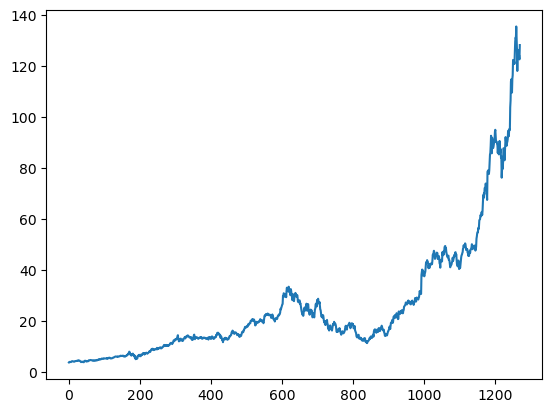

In [42]:
plot_series(nvda)

In [33]:
sma = talib.SMA(nvda, timeperiod=5)

In [40]:
query = '''
SELECT * FROM stocks
WHERE ticker in (
	SELECT ticker FROM stocks
	WHERE time = (
		SELECT MAX(time) FROM stocks
	)
	ORDER BY volume * vw DESC
	LIMIT 5000
)
'''

In [41]:
data = get_data(query)

In [31]:
test.shape

(9535192, 9)

In [42]:
import connectorx as cx

In [49]:
cxtest = cx.read_sql(query, 'sqlite:///main.db')

ValueError: not enough values to unpack (expected 2, got 1)

In [51]:
cxtest = cx.read_sql('sqlite://main.db', query)

RuntimeError: Invalid column type Real at index: 1, name: volume

In [32]:
df.shape

(9535192, 9)

In [33]:
df.n.min()

1.0

In [38]:
test2 = pd.read_sql_query(query, conn)

In [39]:
test2

,id,parent,notused,detail
0,3,0,0,SEARCH stocks USING INDEX idx_ticker_time (tic...
1,7,0,0,LIST SUBQUERY 2
2,12,7,0,SEARCH stocks USING INDEX idx_time_n (time=?)
3,15,7,0,SCALAR SUBQUERY 1
4,20,15,0,SEARCH stocks USING COVERING INDEX idx_time_n
5,48,7,0,USE TEMP B-TREE FOR ORDER BY


In [35]:
test = pd.read_sql_query(query, conn)

In [16]:
timestamp_to_date(get_data(maxtime)[0][0])

'2024-07-03'

In [ ]:
df.n.min()

In [28]:
df = pd.read_sql_query(get_top_stocks(10000), conn)

In [26]:
df.shape

(11980, 9)

In [27]:
df.ticker.unique()

array(['AAPL', 'AMD', 'AMZN', 'AVGO', 'META', 'NVDA', 'QQQ', 'SMCI',
       'SPY', 'TSLA'], dtype=object)

In [10]:
def get_top_stocks(n=5000, all=True):
    select = '*' if all else 'ticker, time, close'
    command = f'''
        SELECT {select} FROM stocks
        WHERE ticker in (
            SELECT ticker FROM stocks
            WHERE time = (
                SELECT MAX(time) FROM stocks
            )
            ORDER BY volume * vw DESC
            LIMIT {n}
        )
        '''

    return command

In [21]:
df.shape

(11980, 9)

In [20]:
df.head()

,0,1,2,3,4,5,6,7,8
0,AAPL,58676576,48.5258,48.2250,48.4725,48.7400,48.0425,1560801600000,114807
1,AAPL,106204016,49.6892,49.0125,49.6125,50.0725,48.8025,1560888000000,213982
2,AAPL,84496940,49.5686,49.9200,49.4675,49.9700,49.3275,1560974400000,155701
3,AAPL,85875952,49.8312,50.0925,49.8650,50.1525,49.5075,1561060800000,168119
4,AAPL,191202356,49.8109,49.7000,49.6950,50.2125,49.5375,1561147200000,182762


In [19]:
df = pd.DataFrame(df)

In [17]:
df = get_data(get_top_stocks(10))

In [ ]:
onlylast = '''
    SELECT ticker FROM stocks
	WHERE time = (
		SELECT MAX(time) FROM stocks
	)
	ORDER BY volume * vw DESC
    LIMIT 1000;
'''

query = f'''
    SELECT * 
    FROM stocks 
    WHERE time > {timestamp_from_datestring('2024-01-01')}
    AND n > 1000
    '''
	
### test table
beginning = date_to_timestamp('2023-01-01')
end = date_to_timestamp('2024-06-01')
query = f'''
    SELECT * 
    FROM stocks 
    WHERE time > {beginning} AND time < {end}
'''
test = pd.read_sql_query(query, conn)
test.to_sql('test', conn, if_exists='replace', index=False)

In [5]:
date_to_timestamp('2023-01-01')

1672527600000

In [4]:
date_from_timestamp(1704063600000)

'2024-01-01'

In [6]:
def get_data(query):
    c.execute(query)
    data = c.fetchall()
    return data

In [7]:
timestamps = pd.read_sql_query('SELECT DISTINCT time FROM stocks', conn)
dates = [date_from_timestamp(ts) for ts in timestamps['time']]

In [20]:
date = get_trading_days(from_date=max(dates))[1]

In [44]:
last_timestamp = pd.read_sql_query('SELECT MAX(time) FROM stocks', conn).iloc[0,0]

In [43]:
missingdates(dates, get_trading_days(from_date=min(dates)))

['2024-06-17']

In [16]:
tablename = 'test'

In [56]:
timestamps = pd.read_sql_query(f'SELECT DISTINCT time FROM {tablename}', conn)
dates = [date_from_timestamp(ts) for ts in timestamps['time']]
trading_days = get_trading_days(from_date=min(dates))[1:]
missingdates = missingdates(dates, trading_days)

In [57]:
missingdates

['2024-02-01',
 '2024-02-02',
 '2024-02-05',
 '2024-02-06',
 '2024-02-07',
 '2024-02-08',
 '2024-02-09',
 '2024-02-12',
 '2024-02-13',
 '2024-02-14',
 '2024-05-31',
 '2024-06-03',
 '2024-06-04',
 '2024-06-05',
 '2024-06-06',
 '2024-06-07',
 '2024-06-10',
 '2024-06-11',
 '2024-06-12',
 '2024-06-13',
 '2024-06-14',
 '2024-06-17']

In [79]:
datetime.fromtimestamp(1706821200000 / 1000).strftime('%Y-%m-%d-%H-%M-%S')

'2024-02-01-22-00-00'

In [36]:
newdf.columns = get_table_colnames('test')

In [40]:
newdf.to_sql('test', conn, if_exists='append', index=False)

105428

In [80]:
all = pd.read_sql_query('SELECT * FROM stocks', conn)

In [81]:
allstamps = all['time'].unique()

In [82]:
len(allstamps)

1259

In [89]:
datetime.fromtimestamp(1706821200000 / 1000).hour


22

In [90]:
times = [datetime.fromtimestamp(i / 1000).hour for i in allstamps]

In [91]:
set(times)

{21, 22}

In [94]:
import numpy as np

In [96]:
times = np.array(times)

In [100]:
dates = [datetime.fromtimestamp(i / 1000).strftime('%Y-%m-%d') for i in allstamps]

In [99]:
sum(times == 22)

1175

In [103]:
test = pd.read_sql_query('SELECT * FROM test', conn)

In [104]:
date_from_timestamp(test.time.max())

'2024-06-17'

In [106]:
test.shape

(3870260, 9)

In [107]:
all2 = all[all.time >= test.time.min()]

In [108]:
all2.shape

(3869373, 9)

In [109]:
all2.shape[0] - test.shape[0]

-887

In [120]:
mintest = test[test.time == test.time.min()]

In [121]:
all2min = all2[all2.time == all2.time.min()]

In [125]:
test.time.min()

1672779600000

In [126]:
all2.time.min()

1672779600000

In [127]:
test.time.max()

1718395200000

In [128]:
all2.time.max()

1718395200000

In [131]:
test[test.ticker == 'STRR'].tail(10)

,ticker,volume,vw,open,close,high,low,time,n
3771990,STRR,13991.6,4.1965,4.2500,4.2400,4.2550,4.1005,1717444800000,244.0
3783019,STRR,16194.0,4.1660,4.1500,4.2000,4.2400,4.1245,1717531200000,166.0
3794600,STRR,21491.0,4.1540,4.1995,4.1753,4.1995,4.1250,1717617600000,210.0
3801380,STRR,2690.6,4.1965,4.1495,4.2000,4.2450,4.1495,1717704000000,92.0
3812713,STRR,2645.8,4.2215,4.3500,4.1255,4.3500,4.1000,1717790400000,56.0
3817810,STRR,965.8,4.2030,4.3500,4.1550,4.3500,4.1265,1718049600000,59.0
3835916,STRR,5349.6,4.1810,4.1775,4.1980,4.2000,4.1550,1718136000000,96.0
3839242,STRR,47165.0,4.1610,4.1500,4.2225,4.3000,4.1000,1718222400000,41092.0
3854857,STRR,38172.2,4.0575,4.1700,4.1620,4.2465,3.8050,1718308800000,18916.0
3859937,STRR,58309.2,4.0940,4.1170,4.1500,4.2500,3.9550,1718395200000,42849.0


In [1]:
4.2500 / 0.8393

5.063743595853687

In [138]:
strr.tail(10)

,v,vw,o,c,h,l,t,n
0,13991.6,4.1965,4.2500,4.2400,4.2550,4.1005,1717387200000,244
1,16194.0,4.1660,4.1500,4.2000,4.2400,4.1245,1717473600000,166
2,21491.0,4.1540,4.1995,4.1753,4.1995,4.1250,1717560000000,210
3,2690.6,4.1965,4.1495,4.2000,4.2450,4.1495,1717646400000,92
4,2645.8,4.2215,4.3500,4.1255,4.3500,4.1000,1717732800000,56
5,965.8,4.2030,4.3500,4.1550,4.3500,4.1265,1717992000000,59
6,5349.6,4.1810,4.1775,4.1980,4.2000,4.1550,1718078400000,96
7,47165.0,4.1610,4.1500,4.2225,4.3000,4.1000,1718164800000,41092
8,38172.2,4.0575,4.1700,4.1620,4.2465,3.8050,1718251200000,18916
9,58309.2,4.0940,4.1170,4.1500,4.2500,3.9550,1718337600000,42849


In [132]:
all2[all2.ticker == 'STRR'].tail(10)

,ticker,volume,vw,open,close,high,low,time,n
12581560,STRR,69958.0,0.8393,0.850000,0.84800,0.8510,0.820100,1717444800000,244.0
12592533,STRR,80970.0,0.8332,0.829999,0.84000,0.8480,0.824899,1717531200000,166.0
12604112,STRR,107455.0,0.8308,0.839900,0.83505,0.8399,0.824999,1717617600000,210.0
12611049,STRR,13453.0,0.8393,0.829900,0.84000,0.8490,0.829900,1717704000000,92.0
12622225,STRR,13229.0,0.8443,0.870000,0.82510,0.8700,0.820000,1717790400000,56.0
12627322,STRR,4829.0,0.8406,0.870000,0.83100,0.8700,0.825300,1718049600000,59.0
12645428,STRR,26748.0,0.8362,0.835500,0.83960,0.8400,0.831000,1718136000000,96.0
12648754,STRR,235825.0,0.8322,0.830000,0.84450,0.8600,0.820000,1718222400000,41092.0
12658972,STRR,190861.0,0.8115,0.834000,0.83240,0.8493,0.761000,1718308800000,18916.0
12669561,STRR,120992.0,0.8072,0.823400,0.80570,0.8500,0.791000,1718395200000,14598.0


In [140]:
all[all.volume == 107455.0]

,ticker,volume,vw,open,close,high,low,time,n
875971,AIR,107455.0,43.4751,44.0800,43.350000,44.2900,43.140000,1573246800000,1889.0
1231422,PML,107455.0,15.6112,15.6500,15.590000,15.6500,15.550000,1578690000000,296.0
3564307,GIXr,107455.0,0.5091,0.5500,0.484599,0.6000,0.460400,1611867600000,139.0
4303389,VEI,107455.0,13.0496,12.7600,13.060000,13.1573,12.760000,1621022400000,1371.0
4489146,TGS,107455.0,5.6453,5.7000,5.650000,5.7200,5.570000,1623355200000,798.0
5272873,UNCY,107455.0,2.8230,2.8300,2.780000,2.8700,2.750000,1632772800000,436.0
6366123,YYY,107455.0,15.3362,15.2400,15.350000,15.3900,15.240000,1645045200000,498.0
8736181,ATMVU,107455.0,10.0510,10.0400,10.040000,10.0700,10.040000,1671656400000,450.0
9814011,ENTF,107455.0,10.5700,10.5700,10.570000,10.5800,10.560000,1684267200000,14.0
10479085,FEM,107455.0,21.4562,21.4000,21.400000,21.6300,21.390000,1692216000000,461.0


In [142]:
df = pd.read_csv('all_dailies.csv')

In [143]:
df[df.ticker == 'STRR'].tail(10)

,ticker,volume,open,close,high,low,window_start,transactions,date
12882391,STRR,20653,0.9000,0.879900,0.910000,0.8799,1715918400000000000,111,2024-05-17
12892895,STRR,166319,0.9301,0.907100,0.950000,0.8799,1716177600000000000,394,2024-05-20
12903401,STRR,61911,0.9200,0.890000,0.950001,0.8900,1716264000000000000,138,2024-05-21
12913961,STRR,7208,0.9100,0.900000,0.910100,0.9000,1716350400000000000,79,2024-05-22
12924480,STRR,9387,0.9000,0.910000,0.939900,0.8900,1716436800000000000,85,2024-05-23
12934962,STRR,7453,0.9000,0.900000,0.940000,0.8905,1716523200000000000,120,2024-05-24
12945483,STRR,27413,0.9100,0.890000,0.910000,0.8900,1716868800000000000,137,2024-05-28
12955988,STRR,14054,0.9001,0.889401,0.900100,0.8894,1716955200000000000,53,2024-05-29
12966466,STRR,29199,0.8800,0.870000,0.899100,0.8700,1717041600000000000,161,2024-05-30
12976976,STRR,52171,0.8700,0.860000,0.899900,0.8600,1717128000000000000,182,2024-05-31


In [133]:
date_from_timestamp(1717444800000)

'2024-06-03'

In [146]:
strr = pd.DataFrame(single_stock('STRR', '2021-06-03', '2024-06-14')['results'])

In [149]:
test[test.ticker=='CPIX']

,ticker,volume,vw,open,close,high,low,time,n
3263,CPIX,17222.0,2.3182,2.2500,2.31,2.3625,2.2400,1672779600000,92.0
13983,CPIX,17871.0,2.3539,2.3100,2.37,2.3799,2.3000,1672866000000,77.0
24454,CPIX,6630.0,2.3640,2.3100,2.41,2.4244,2.2667,1672952400000,44.0
36092,CPIX,8544.0,2.4399,2.2400,2.43,2.4800,2.2400,1673038800000,82.0
47374,CPIX,35111.0,2.4870,2.4100,2.51,2.5500,2.4100,1673298000000,114.0
...,...,...,...,...,...,...,...,...,...
3821981,CPIX,8760.0,1.4757,1.3800,1.42,1.5508,1.3800,1718049600000,128.0
3835528,CPIX,2118.0,1.4921,1.4400,1.53,1.5899,1.4400,1718136000000,49.0
3846739,CPIX,1660.0,1.5256,1.4600,1.51,1.5900,1.4600,1718222400000,61.0
3856164,CPIX,3691.0,1.5321,1.4600,1.55,1.5500,1.4600,1718308800000,190.0


In [151]:
date_from_timestamp(1718395200000)

'2024-06-14'

In [150]:
all2[all2.ticker=='CPIX']

,ticker,volume,vw,open,close,high,low,time,n
8818525,CPIX,17222.0,2.3182,2.2500,2.31,2.3625,2.2400,1672779600000,92.0
8828579,CPIX,17871.0,2.3539,2.3100,2.37,2.3799,2.3000,1672866000000,77.0
8839375,CPIX,6630.0,2.3640,2.3100,2.41,2.4244,2.2667,1672952400000,44.0
8847954,CPIX,8544.0,2.4399,2.2400,2.43,2.4800,2.2400,1673038800000,82.0
8861599,CPIX,35111.0,2.4870,2.4100,2.51,2.5500,2.4100,1673298000000,114.0
...,...,...,...,...,...,...,...,...,...
12625732,CPIX,1841.0,1.4105,1.4308,1.39,1.4308,1.3900,1717790400000,104.0
12631493,CPIX,8760.0,1.4757,1.3800,1.42,1.5508,1.3800,1718049600000,128.0
12645010,CPIX,2118.0,1.4921,1.4400,1.53,1.5899,1.4400,1718136000000,49.0
12656251,CPIX,1660.0,1.5256,1.4600,1.51,1.5900,1.4600,1718222400000,61.0
